In [305]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import time

import properties as prop
import random_initialization as rand_init
import matrixes as ma
import interblock_matrixes as i_ma
import utils as u

imp.reload(prop)
imp.reload(rand_init)
imp.reload(ma)
imp.reload(i_ma)
imp.reload(u)

const = prop.Constants()

In [306]:
ns = 50000
x_min, x_max = -1.3, 1.3
y_min, y_max = -1.3, 1.3
nx , ny = 15, 15

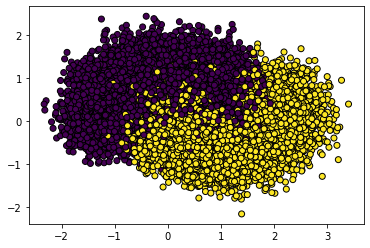

In [307]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.4)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()

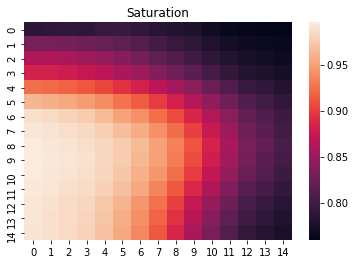

In [308]:
Satur_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=1, x_min=-1,
                                                 y_min=-1, y_max=1, n_x=nx, n_y=ny
                                                )
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

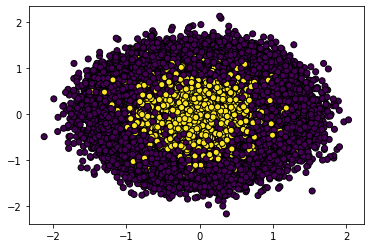

In [309]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()  

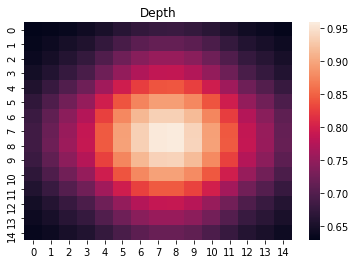

In [310]:
depth_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max, n_x=nx, n_y=ny
                                                )
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

In [311]:
depth_matrix *= const.depth_avg()

In [312]:
assert np.isnan(depth_matrix).sum() == 0

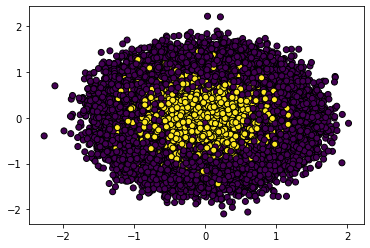

In [313]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()   

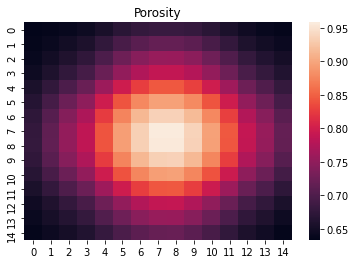

In [314]:
porosity_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max, n_x=nx, n_y=ny
                                                )
sns.heatmap(porosity_matrix)
plt.title("Porosity")
plt.show()

In [315]:
assert np.isnan(porosity_matrix).sum() == 0

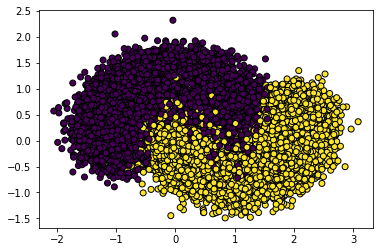

In [316]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.3)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show() 

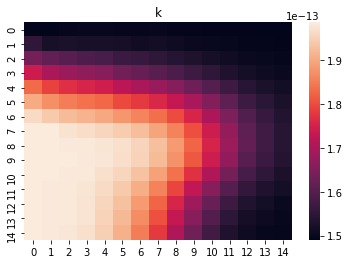

In [317]:
k_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max-0.1, x_min=x_min+0.1,
                                             y_min=y_min+0.1, y_max=y_max-0.1, n_x=nx, n_y=ny
                                            )
k_matrix *= const.k_avg()
sns.heatmap(k_matrix)
plt.title("k")
plt.show()

In [318]:
assert np.isnan(k_matrix).sum() == 0

Давления пусть будут одинаково распределены

In [319]:
dy = np.ones(ny) * const.dy()
dx = np.ones(nx) * const.dx()

p_vec = np.ones((nx*ny)) * const.p_0()
S_o_vec = Satur_matrix.reshape(-1)
S_w_vec = (np.ones(Satur_matrix.shape) - Satur_matrix).reshape(-1)

Обозначем важные прмежуточные матрицы для 
$$\vec{p^{n+1}} = \vec{p^{n}} + \Delta t \big[B^{p, w}\big]^{-1}\big[ T^{upd}_{\tilde{k}} \vec{p} + \tilde{Q} + \frac{B_o}{B_w} q_o^{well} + q_w^{well}\big]$$

In [320]:
b_p_w = ma.get_b_p_w(porosity_matrix, const)
depth_m = i_ma.DMatrix(depth_matrix * const.depth_avg())
k_matrix_0 = i_ma.KMatrix(k_values=k_matrix,
                         dy_matrix=dy,
                         dx_matrix=dx)
k_tilde = ma.get_k_tilde(consts=const, k=k_matrix_0)
t_k_tilde = i_ma.TInterBlockMatrix(k_matrix=k_tilde,
                                      dx_matrix=dx,
                                      dy_matrix=dy, 
                                      d_matrix=depth_m,
                                 boundary_condition='no_flux'
                                  )
t_upd_k_tilde = ma.get_t_upd_matrix(t_k_tilde)

In [321]:
b_s_o = ma.get_b_s_o(consts=const, porosity=porosity_matrix)
k_s_o = ma.get_k_s_o(consts=const, k=k_matrix_0)
t_k_s_o = i_ma.TInterBlockMatrix(k_matrix=k_s_o,
                                 dx_matrix=dx,
                                 dy_matrix=dy,
                                 d_matrix=depth_m,
                                 boundary_condition='no_flux'
                                )
t_upd_k_s_o = ma.get_t_upd_matrix(t_k_s_o)

In [322]:
b_s_w = ma.get_b_s_o(consts=const, porosity=porosity_matrix)
k_s_w = ma.get_k_s_w(consts=const, k=k_matrix_0)
t_k_s_w = i_ma.TInterBlockMatrix(k_matrix=k_s_w,
                                      dx_matrix=dx,
                                      dy_matrix=dy, 
                                      d_matrix=depth_m,
                                 boundary_condition='no_flux')
t_upd_k_s_w = ma.get_t_upd_matrix(t_k_s_w)

In [323]:
well_ind = u.two_dim_index_to_one(i=7, j=7, ny=ny)

In [324]:
dict_wells = {well_ind: -1e-2
             }

In [325]:
b_rat = const.b_o() / const.b_w()
q_w, q_o = ma.get_q_well(dict_wells,s_w=S_w_vec, s_o=S_o_vec, nx=nx, ny=ny)
bpw_inv = ma.inverse_diag(b_p_w)
por_mat_diag = np.diag(porosity_matrix.reshape(-1))
por_inv = ma.inverse_diag(por_mat_diag)
v_matrix = np.diag(const.dx() * const.dy() * depth_matrix.reshape(-1))
v_matrix_inv = ma.inverse_diag(v_matrix)

In [326]:
bpw_inv[2, 2]

472606604.96208835

In [327]:
tri_matr_o = ma.diagonal_multidot([por_inv, b_s_o, v_matrix_inv])
tri_matr_w = ma.diagonal_multidot([por_inv, b_s_w, v_matrix_inv])
two_diag_dot = ma.diagonal_multidot([v_matrix_inv, por_inv])

In [328]:
inv_p_upd = np.linalg.inv(np.eye(nx*ny, dtype=float) + const.dt() * bpw_inv.dot(t_upd_k_tilde))

In [335]:
n_it = int(1e3)
q_o_rate = []
s_o_well = []
s_w_well = []
q_w, q_o = ma.get_q_well(dict_wells, s_w=S_w_vec, s_o=S_o_vec, nx=nx, ny=ny)
for i in range(n_it):
    q_w, q_o = ma.get_q_well(dict_wells, s_w=S_w_vec, s_o=S_o_vec, nx=nx, ny=ny)
    q_o_rate.append(-1 * q_o.sum())
    
    s_w_well.append(S_w_vec[well_ind])
    s_o_well.append(S_o_vec[well_ind])
    
    q_tilde_p = ma.get_q_bound(t_k_tilde, const.p_0())
    q_tilde_w = ma.get_q_bound(t_k_s_w, const.p_0())
    
    p_vec_new = p_vec + const.dt() * bpw_inv.dot(q_tilde_p + b_rat * q_o  + q_w)
    p_vec_new = inv_p_upd.dot(p_vec_new)

    S_o_vec_new = S_o_vec  + tri_matr_o.dot(p_vec_new - p_vec) * const.b_o()
    S_o_vec_new += const.dt() * const.b_o() * two_diag_dot.dot(-1 * t_upd_k_s_o.dot(p_vec_new) + q_o)

    S_w_vec_new = S_w_vec + tri_matr_w.dot(p_vec_new - p_vec) * const.b_w() 
    S_w_vec_new += const.dt() * const.b_w() * two_diag_dot.dot(-1 * t_upd_k_s_w.dot(p_vec_new) + q_w + q_tilde_w)
    
    p_vec = p_vec_new
    S_o_vec = S_o_vec_new
    S_w_vec = S_w_vec_new
    if i % 50 == 0:
        S_o_vec_d = S_o_vec.copy()
        S_w_vec_d = S_w_vec.copy()
        p_vec_d = p_vec.copy()
        
        for k in dict_wells:
            # S_o_vec_d[k] = np.nan
            # S_w_vec_d[k] = np.nan
            # p_vec_d[k] = np.nan
            pass
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
        ax[0][0].get_shared_y_axes().join(ax[0][1])
        g1 = sns.heatmap(p_vec_d.reshape(nx, ny) / const.p_0(), ax=ax[0][0], cbar=True)
        g1.set_title('Pressure / p_0')
        g2 = sns.heatmap(S_o_vec_d.reshape(nx, ny), ax=ax[0][1], cbar=True)
        g2.set_title('Saturation oil')

        # may be needed to rotate the ticklabels correctly:
        for _ax in [g1,g2]:
            tl = _ax.get_xticklabels()
            _ax.set_xticklabels(tl, rotation=90)
            tly = _ax.get_yticklabels()
            _ax.set_yticklabels(tly, rotation=0)
        g3 = sns.heatmap(S_w_vec_d.reshape(nx, ny), ax=ax[1][0], cbar=True)
        g3.set_title('Saturation water')
        g4 = sns.heatmap(np.ones((nx, ny)) - S_w_vec_d.reshape(nx, ny) - S_o_vec_d.reshape(nx, ny), ax=ax[1][1], cbar=True)
        g4.set_title('1 - Saturation sum')
        
        ax[2][0].plot(s_w_well, label='water')
        ax[2][0].plot(s_o_well, label='oil')
        ax[2][0].set_title('Oil and water saturation')
        ax[2][0].legend()
        
        ax[2][1].plot(q_o_rate)
        ax[2][1].set_title('Oil rate')
        
        plt.show()
print()

KeyboardInterrupt: 

In [336]:
p_vec_new[13] / const.p_0()

0.13839345750128218

In [ ]:
S_o_vec[well_ind], S_w_vec[well_ind], q_o[well_ind], q_w[well_ind]

In [ ]:
v_matrix_inv[well_ind, well_ind], por_inv[well_ind, well_ind]

In [ ]:
two_diag_dot[well_ind, well_ind]

In [ ]:
v_matrix = np.diag(const.dx() * const.dy() * depth_matrix.reshape(-1))

In [ ]:
v_matrix

In [ ]:
const.dt() * const.b_o() * por_inv[wzell_ind, well_ind] * (q_o[well_ind]) * v_matrix_inv[well_ind, well_ind]

In [ ]:
v_matrix[well_ind, well_ind]

In [ ]:
q_tilde_p[u.two_dim_index_to_one(i=2, j=0, ny=ny)]

In [ ]:
t_k_s_w[1, +0.5]

In [ ]:
p_vec_new[] / const.p_0()

In [ ]:
p_vec_new[u.two_dim_index_to_one(i=14, j=0, ny=ny)] / const.p_0()

In [ ]:
S_w_vec[u.two_dim_index_to_one(i=14, j=0, ny=ny)]

In [ ]:
1 - Satur_matrix[5, 0]

In [ ]:
t_upd_k_s_w[0, 0], t_upd_k_s_w[1, 1]

In [ ]:
Satur_matrix[6, 7], S_o_vec[u.two_dim_index_to_one(i=6, j=7, ny=ny)]